# **CSC420 Assignment 2**
Written by Liwei Yang, discussed with Muxin Tian.

# **TASK 2 PART I**

# **Package importing and data preparation**

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
from google.colab import drive
%matplotlib inline

**Load SDD and DBI.**

In [ ]:
drive.mount('/content/drive')
SDDdataset = ImageFolder('/content/drive/MyDrive/CSC420/SDDsubset')
DBIdataset = ImageFolder('/content/drive/MyDrive/CSC420/DBIsubset')
# TODO: Swtich dataset here!
dataset = DBIdataset
dataset2 = SDDdataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(n)
    # breeds.append(rename(n))

breeds

['bernese_mountain_dog',
 'border_collie',
 'chihuahua',
 'golden_retriever',
 'labrador_retriver',
 'pug',
 'siberian_husky']

In [ ]:
breeds2 = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset2.classes:
    breeds2.append(n)
breeds2

['bernese_mountain_dog',
 'border_collie',
 'chihuahua',
 'golden_retriever',
 'labrador_retriever',
 'pug',
 'siberian_husky']

# **Configure the model and datasets**

In [ ]:
random_seed = 45
torch.manual_seed(random_seed);

In [ ]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train_size, val_size, test_size

(408, 45, 193)

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(408, 45, 193)

In [ ]:
train_ds2, val_ds2, test_ds2 = random_split(dataset, [train_size, val_size, test_size])
len(train_ds2), len(val_ds2), len(test_ds2)

(408, 45, 193)

golden_retriever
<class 'PIL.Image.Image'>


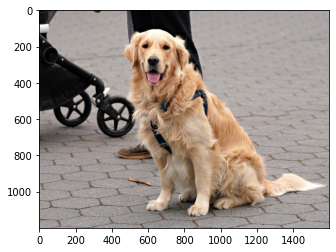

In [ ]:
# Test
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [ ]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats, inplace=True)
])

entire_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(*imagenet_stats, inplace=True)
])

In [ ]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)
DBIdataset = DogBreedDataset(dataset, test_transform)

train_dataset2 = DogBreedDataset(train_ds2, train_transform)
val_dataset2 = DogBreedDataset(val_ds2, val_transform)
test_dataset2 = DogBreedDataset(test_ds2, test_transform)
SDDdataset = DogBreedDataset(dataset2, test_transform)

Augmenting the dataset for better generalization & prevent overfitting

3


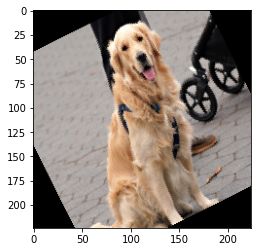

In [ ]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)
DBI_dl = DataLoader(DBIdataset, batch_size*2, num_workers=2, pin_memory=True)

train_dl2 = DataLoader(train_dataset2, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl2 = DataLoader(val_dataset2, batch_size*2, num_workers=2, pin_memory=True)
test_dl2 = DataLoader(test_dataset2, batch_size*2, num_workers=2, pin_memory=True)
SDD_dl = DataLoader(SDDdataset, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

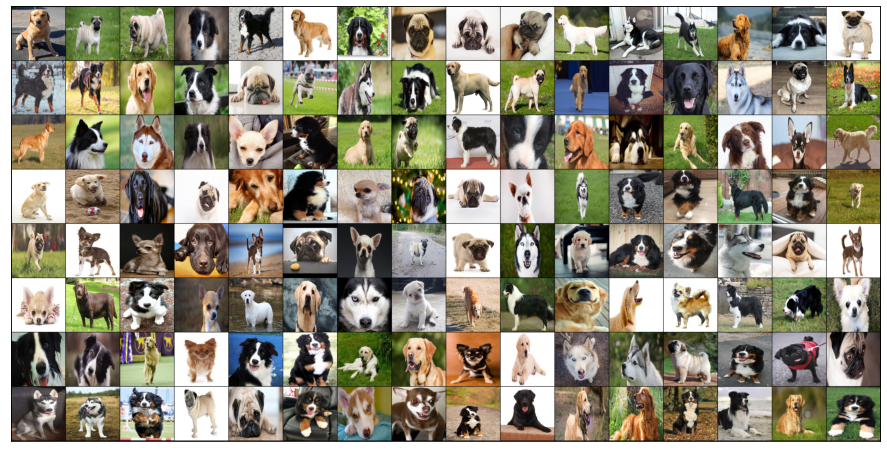

In [ ]:
show_batch(test_dl2)

# **TASK 2 PART II**

# **Setting up the Neural Network**

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.cross_entropy(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

# Setting up the customized model, w/o dropout. (untrained)

**Setting up the model, we used the exact parameters as givin in part 2.**

In [ ]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),   # 224 * 224 * 16
            nn.ReLU(),                                   
            nn.BatchNorm2d(16),
            # Normalize
            nn.Conv2d(16, 16, 3, stride=1, padding=1),  # 224 * 224 * 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 16
            
            nn.Conv2d(16, 8, 3, stride=1, padding=1),   # 112 * 112 * 8
            nn.ReLU(), 
            nn.BatchNorm2d(8),
            # Normalize
            nn.Conv2d(8, 8, 3, stride=1, padding=1),    # 112 * 112* 8
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 8
            # nn.Dropout(0.5, inplace=False),

            nn.Flatten(),
            nn.Linear(56*56*8, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
            # nn.Dropout(0.5, inplace=False),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

# Setting up the customized model, w/ dropout. (untrained)

In [ ]:
class DogBreedClassificationCNNwithDropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1),   # 224 * 224 * 16
            nn.ReLU(),                                   
            nn.BatchNorm2d(16),
            # Normalize
            nn.Conv2d(16, 16, 3, stride=1, padding=1),  # 224 * 224 * 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 16
            
            nn.Conv2d(16, 8, 3, stride=1, padding=1),   # 112 * 112 * 8
            nn.ReLU(), 
            nn.BatchNorm2d(8),
            # Normalize
            nn.Conv2d(8, 8, 3, stride=1, padding=1),    # 112 * 112* 8
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 8
            nn.Dropout(0.5, inplace=False),

            nn.Flatten(),
            nn.Linear(56*56*8, 32),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.Dropout(0.5, inplace=False),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        # return torch.device('gpu')
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

# Setting up the Resnet18 (untrained)

In [ ]:
class DogBreedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=False)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

# Setting up the Resnet18 (pretrained)

In [ ]:
class DogBreedResnet18Pretrained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

# Setting up the ResNeXt32 (pretrained)



In [ ]:
class DogBreedResNeXt32Pretrained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

# Setting up the Resnet34 (pretrained)



In [ ]:
class DogBreedResnet34Pretrained(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

# Creating the (new) models

In [ ]:
model = DogBreedClassificationCNN()
model

DogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=25088, out_features=32, bias=True)
    (14): ReLU()
    (15): Linear(in_features=32, out_features=7, bias=True)
    (16): LogSoftmax(dim=1)
  )
)

In [ ]:
modelwdropout = DogBreedClassificationCNNwithDropout()
modelwdropout

DogBreedClassificationCNNwithDropout(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.5, inplace=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=25088, out_features=32, bias=True)
    (15): ReLU()
    (16): Linear(in_features=32, out_features=7, bias=True)
    (1

In [ ]:
model2 = DogBreedResnet18()
model2

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DogBreedResnet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
model3_DBI = DogBreedResnet18Pretrained()
model3_DBI

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

DogBreedResnet18Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [ ]:
model3_SDD = DogBreedResnet18Pretrained()
model3_SDD

DogBreedResnet18Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [ ]:
model4_DBI = DogBreedResNeXt32Pretrained()
model4_DBI

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

DogBreedResNeXt32Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [ ]:
model4_SDD = DogBreedResNeXt32Pretrained()
model4_SDD

DogBreedResNeXt32Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

In [ ]:
model5_DBI = DogBreedResnet34Pretrained()
model5_DBI

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

DogBreedResnet34Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [ ]:
model5_SDD = DogBreedResnet34Pretrained()
model5_SDD

DogBreedResnet34Pretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
DBI_dl = DeviceDataLoader(DBI_dl, device)


train_dl2 = DeviceDataLoader(train_dl2, device)
val_dl2 = DeviceDataLoader(val_dl2, device)
test_dl2 = DeviceDataLoader(test_dl2, device)
SDD_dl = DeviceDataLoader(SDD_dl, device)



# moving model to gpu
model = to_device(model, device);
modelwdropout = to_device(modelwdropout, device);
model2 = to_device(model2, device);
model3_DBI = to_device(model3_DBI, device);
model4_DBI = to_device(model4_DBI, device);
model5_DBI = to_device(model5_DBI, device);
model3_SDD = to_device(model3_SDD, device);
model4_SDD = to_device(model4_SDD, device);
model5_SDD = to_device(model5_SDD, device);

cuda


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader, train_loader, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader, train_loader, test_loader):
    # I added train accuracy here
    model.eval()
    val_outputs = [model.validation_step(batch) for batch in val_loader]
    train_outputs = [model.validation_step(batch) for batch in train_loader]
    test_outputs = [model.validation_step(batch) for batch in test_loader]

    output_val = model.validation_epoch_end(val_outputs)
    output_train = model.validation_epoch_end(train_outputs)
    output_test = model.validation_epoch_end(test_outputs)
    output = output_val
    output['test_acc'] = output_test['val_acc']
    output['train_acc'] = output_train['val_acc']
    return output

In [ ]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model2(imgs)                            # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([5, 6, 4, 6, 1, 1, 6, 3, 0, 6, 4, 0, 6, 2, 0, 4, 0, 3, 3, 5, 6, 3, 6, 5,
        1, 4, 3, 0, 1, 0, 6, 2, 5, 4, 2, 5, 1, 0, 0, 4, 3, 4, 5, 5, 2, 0, 6, 0,
        6, 2, 5, 4, 2, 5, 4, 4, 0, 5, 4, 6, 1, 0, 6, 1], device='cuda:0')
outs.shape : torch.Size([64, 7])
outs :  tensor([[-2.2229, -1.8917, -1.8907, -1.9337, -2.0947, -1.5445, -2.2184],
        [-2.0895, -1.8660, -1.7993, -1.9709, -2.1492, -1.5910, -2.3388],
        [-2.3473, -1.6289, -1.9193, -2.0011, -2.2947, -1.5328, -2.2108],
        [-2.3171, -1.7725, -1.9023, -1.9101, -2.2043, -1.5392, -2.2132],
        [-2.1676, -1.8714, -1.7823, -2.1885, -2.1042, -1.5422, -2.1588],
        [-2.2289, -1.7950, -1.7775, -1.9263, -2.2209, -1.6125, -2.2675],
        [-2.5495, -1.4642, -2.0495, -1.9572, -2.5998, -1.4060, -2.2912],
        [-2.2856, -1.8996, -1.6263, -2.0747, -2.1299, -1.6196, -2.2111],
        [-2.2231, -1.7952, -1.9455, -1.8206, -2.1629, -1.6472, -2.1786],
        [-2.

# **Model training** 
(Customized model w/o dropout, resnet 18 untrained)

In [ ]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history_mymodel = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 1.9443, val_loss: 1.9386, val_acc: 0.1556


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.8970, val_loss: 1.9351, val_acc: 0.1778


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 1.7498, val_loss: 1.9293, val_acc: 0.1333


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 1.6525, val_loss: 1.8440, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.5464, val_loss: 1.6439, val_acc: 0.3778


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.4628, val_loss: 1.6040, val_acc: 0.3556


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.4778, val_loss: 1.6362, val_acc: 0.3111


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.3736, val_loss: 1.5648, val_acc: 0.3333


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.3494, val_loss: 1.5748, val_acc: 0.3778


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.3242, val_loss: 1.5580, val_acc: 0.3556


In [ ]:
history_mymodel_dropout = fit_one_cycle(num_epochs, max_lr, modelwdropout, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 1.9698, val_loss: 1.9539, val_acc: 0.0889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.9536, val_loss: 1.9612, val_acc: 0.0889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 1.8812, val_loss: 1.9626, val_acc: 0.0889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 1.8673, val_loss: 1.8710, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.8582, val_loss: 1.8483, val_acc: 0.3556


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.8623, val_loss: 1.8019, val_acc: 0.2889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.7902, val_loss: 1.7516, val_acc: 0.2889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.7713, val_loss: 1.7045, val_acc: 0.3111


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.7232, val_loss: 1.6794, val_acc: 0.3111


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.7628, val_loss: 1.6593, val_acc: 0.2889


In [ ]:
history_resnet = fit_one_cycle(num_epochs, max_lr, model2, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 1.9829, val_loss: 1.9771, val_acc: 0.0889


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 1.9518, val_loss: 1.9749, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 1.8644, val_loss: 2.0148, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 1.7532, val_loss: 1.9424, val_acc: 0.1556


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 1.7131, val_loss: 1.8612, val_acc: 0.3333


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 1.6214, val_loss: 1.9564, val_acc: 0.2444


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 1.6426, val_loss: 2.8588, val_acc: 0.1556


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 1.5108, val_loss: 1.7903, val_acc: 0.2000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 1.4333, val_loss: 1.7625, val_acc: 0.4000


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 1.3859, val_loss: 1.7283, val_acc: 0.4444


# **TASK 2 PART II and III.a**

# **Load the training history of customized model and Resnet18 for plotting and analysis.**

In [ ]:
val_loss_my_model = []
train_loss_my_model = []
val_acc_my_model = []
test_acc_my_model = []
train_acc_my_model = []
time = list(range(len(history_mymodel)))
for h in history_mymodel:
    val_loss_my_model.append(h['val_loss'])
    train_loss_my_model.append(h['train_loss'])
    val_acc_my_model.append(h['val_acc'])
    test_acc_my_model.append(h['test_acc'])
    train_acc_my_model.append(h['train_acc'])

In [ ]:
val_loss_dropout = []
train_loss_dropout = []
val_acc_dropout = []
test_acc_dropout = []
train_acc_dropout = []
time = list(range(len(history_mymodel_dropout)))
for h in history_mymodel_dropout:
    val_loss_dropout.append(h['val_loss'])
    train_loss_dropout.append(h['train_loss'])
    val_acc_dropout.append(h['val_acc'])
    test_acc_dropout.append(h['test_acc'])
    train_acc_dropout.append(h['train_acc'])

In [ ]:
val_loss_resnet = []
train_loss_resnet = []
val_acc_resnet = []
test_acc_resnet = []
train_acc_resnet = []
time = list(range(len(history_resnet)))
for h in history_resnet:
    val_loss_resnet.append(h['val_loss'])
    train_loss_resnet.append(h['train_loss'])
    val_acc_resnet.append(h['val_acc'])
    test_acc_resnet.append(h['test_acc'])
    train_acc_resnet.append(h['train_acc'])

# **Plotting the training history of mymodel w/wo dropout and resnet.**
# For Assignment 2 Task II and III.a
Plot the acuracy vs. epoch for mymodel without dropout, mymodel with dropout, and the resnet model. The models are trained for 10 epoches.

**Figure 1:** Accuracy vs. epoch for mymodel without dropout.

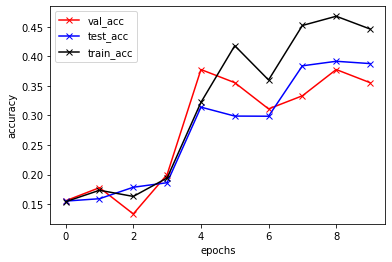

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(time, val_acc_my_model, c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_my_model, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc_my_model, c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('Figure 1.png')

**Figure 2:** Accuracy vs. epoch for mymodel with dropout.

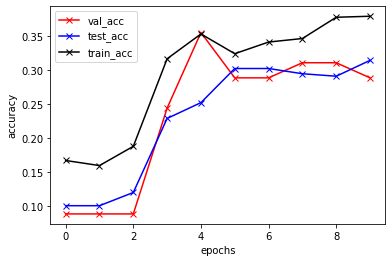

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(time, val_acc_dropout, c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_dropout, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc_dropout, c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('Figure 2.png')

**Figure 3:** Accuracy vs. epoch for resnet18.

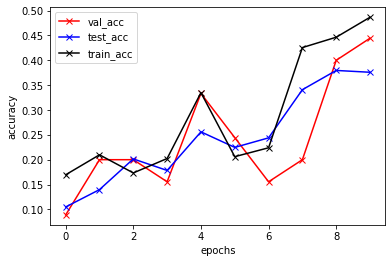

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(time, val_acc_resnet, c='red', label='val_acc', marker='x')
plt.plot(time, test_acc_resnet, c='blue', label='test_acc', marker='x')
plt.plot(time, train_acc_resnet, c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.savefig('Figure 3.png')

# **Task 2 PART III.b**

# **Evaluate the accuracy of the resnet18 model on SDD and DBI.**

Evaluate the accuracy of Resnet-18 **trained with 10 epoches** on DBI and SDD, respectively.

In [ ]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model2(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    # print(breeds[kls], breeds[label])
    # print(breeds)
    return breeds[label] == breeds[kls]

In [ ]:
SDDcorrect = 0
SDDtot = 0
print()
for i in range(len(SDDdataset)):
  if predict_single(*SDDdataset[i]):
    SDDcorrect += 1
  SDDtot += 1
  if i % 100 == 0:
    print (float(i) / float(len(SDDdataset)))

DBIcorrect = 0
DBItot = 0
for i in range(len(DBIdataset)):
  if predict_single(*DBIdataset[i]):
    DBIcorrect += 1
  DBItot += 1
  if i % 100 == 0:
    print (float(i) / float(len(DBIdataset)))


SDD_acc =  float(SDDcorrect) / float(SDDtot)
DBI_acc =  float(DBIcorrect) / float(DBItot)

print('Acc on SDD (whole set):', SDD_acc, 'Acc on DBI (whole set):', DBI_acc)


0.0
0.08110300081103
0.16220600162206
0.24330900243309003
0.32441200324412
0.40551500405515006
0.48661800486618007
0.5677210056772101
0.64882400648824
0.7299270072992701
0.8110300081103001
0.8921330089213301
0.9732360097323601
0.0
0.15479876160990713
0.30959752321981426
0.46439628482972134
0.6191950464396285


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


0.7739938080495357
0.9287925696594427
Acc on SDD (whole set): 0.29927007299270075 Acc on DBI (whole set): 0.43808049535603716


In [ ]:
print('Accuracy of resnet on DBI (test set) is:' , history_resnet[9]['test_acc'])

Accuracy of resnet on DBI (test set) is: 0.375901460647583


# **TASK 2 PART IV**

# Re-train the pre-trained Resnet18, Resnet34, and ResNeXt32.


In [ ]:
history_resnet18trained_DBI = fit_one_cycle(num_epochs, max_lr, model3_DBI, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)
history_resnet34trained_DBI = fit_one_cycle(num_epochs, max_lr, model4_DBI, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)
history_resNeXt32trained_DBI = fit_one_cycle(num_epochs, max_lr, model5_DBI, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 2.0267, val_loss: 1.6051, val_acc: 0.5333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.1680, val_loss: 0.4294, val_acc: 0.9556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.2362, val_loss: 0.1832, val_acc: 0.9111


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0870, val_loss: 0.1569, val_acc: 0.9333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0534, val_loss: 0.0716, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0405, val_loss: 0.0570, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0218, val_loss: 0.0548, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0197, val_loss: 0.0565, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0174, val_loss: 0.0555, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0207, val_loss: 0.0546, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.8388, val_loss: 1.4256, val_acc: 0.6667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.8728, val_loss: 0.1200, val_acc: 0.9556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.1491, val_loss: 0.1114, val_acc: 0.9111


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0342, val_loss: 0.2937, val_acc: 0.8667


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0395, val_loss: 0.0291, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0216, val_loss: 0.0230, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0065, val_loss: 0.0473, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0070, val_loss: 0.0520, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0072, val_loss: 0.0416, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0055, val_loss: 0.0449, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0] : train_loss: 1.8652, val_loss: 1.4457, val_acc: 0.5333


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.8402, val_loss: 0.2517, val_acc: 0.9111


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.1484, val_loss: 0.0783, val_acc: 0.9556


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.0456, val_loss: 0.0484, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0362, val_loss: 0.0403, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.0192, val_loss: 0.0367, val_acc: 1.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.0233, val_loss: 0.0553, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0153, val_loss: 0.0438, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.0145, val_loss: 0.0399, val_acc: 0.9778


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.0144, val_loss: 0.0387, val_acc: 0.9778


# Export the trainng history for plotting
The evaluation was made on the whole dataset.

In [ ]:
def predict_single_usig_different_model(img, label, model_to_eval):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model_to_eval(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    # print(breeds[kls], breeds[label])
    # print(breeds)
    return breeds[label] == breeds[kls]

In [ ]:
SDDcorrect = 0
SDDtot = 0
models = [model3_DBI, model4_DBI, model5_DBI]
DBI_Accuracy = []
for m in models:
  # print(type(m))
  for i in range(len(SDDdataset)):
    if predict_single_usig_different_model(*SDDdataset[i], m):
      SDDcorrect += 1
    SDDtot += 1
    # if i % 100 == 0:
      # print (float(i) / float(len(DBIdataset)))
  a = float(SDDcorrect) / float(SDDtot)
  DBI_Accuracy.append(a)
  print('Accuracy of', type(m), ' on DBI:', a)

Accuracy of <class '__main__.DogBreedResnet18Pretrained'>  on DBI: 0.902676399026764
Accuracy of <class '__main__.DogBreedResNeXt32Pretrained'>  on DBI: 0.9180859691808597
Accuracy of <class '__main__.DogBreedResnet34Pretrained'>  on DBI: 0.9151121924844553


In [ ]:
histories_DBI = [history_resnet18trained_DBI, history_resnet34trained_DBI, history_resNeXt32trained_DBI]
# hist = histories[2]
DBIval_loss = []
DBItrain_loss = []
DBIval_acc = []
DBItest_acc = []
DBItrain_acc = []
for hist in range(len(histories_DBI)):
  DBIval_loss.append(list())
  DBItrain_loss.append(list())
  DBIval_acc.append(list())
  DBItest_acc.append(list())
  DBItrain_acc.append(list())
  time = hist
  for h in histories_DBI[hist]:
      DBIval_loss[hist].append(h['val_loss'])
      DBItrain_loss[hist].append(h['train_loss'])
      DBIval_acc[hist].append(h['val_acc'])
      DBItest_acc[hist].append(h['test_acc'])
      DBItrain_acc[hist].append(h['train_acc'])

# **Plotting the training history of the three models on DBI and SDD.**
# Plotting the result for Assignment 2 Task IV.

**Figure 4:** Resnet18 on DBI

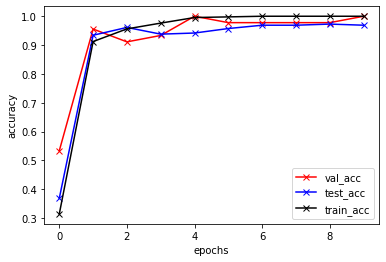

In [ ]:
time = list(range(0, 10, 1))
which_to_show = 0
plt.plot(time, DBIval_acc[which_to_show], c='red', label='val_acc', marker='x')
plt.plot(time, DBItest_acc[which_to_show], c='blue', label='test_acc', marker='x')
plt.plot(time, DBItrain_acc[which_to_show], c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Figure 4.png')
plt.show()

**Figure 5:** Resnet34 on DBI

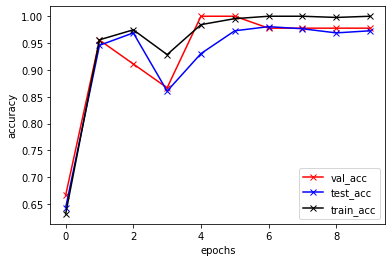

In [ ]:
which_to_show = 1
plt.plot(time, DBIval_acc[which_to_show], c='red', label='val_acc', marker='x')
plt.plot(time, DBItest_acc[which_to_show], c='blue', label='test_acc', marker='x')
plt.plot(time, DBItrain_acc[which_to_show], c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Figure 5.png')
plt.show()

**Figure 6:** ResNeXt32 on DBI

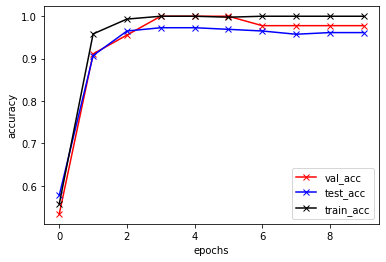

In [ ]:
which_to_show = 2
plt.plot(time, DBIval_acc[which_to_show], c='red', label='val_acc', marker='x')
plt.plot(time, DBItest_acc[which_to_show], c='blue', label='test_acc', marker='x')
plt.plot(time, DBItrain_acc[which_to_show], c='black', label='train_acc', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Figure 6.png')
plt.show()

**Figure 10:** Compare test accuracy on DBI


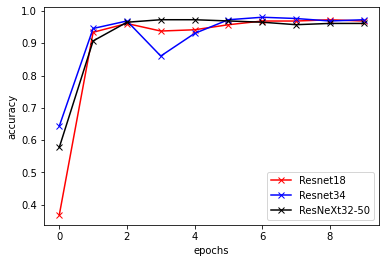

In [ ]:
plt.plot(time, DBItest_acc[0], c='red', label='Resnet18', marker='x')
plt.plot(time, DBItest_acc[1], c='blue', label='Resnet34', marker='x')
plt.plot(time, DBItest_acc[2], c='black', label='ResNeXt32-50', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Figure 10.png')
plt.show()